In [12]:
import os
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
# from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')

In [13]:
aws_psql_conn = psycopg2.connect(
    database=os.getenv("AWS_PSQL_DB"),
    user=os.getenv("AWS_PSQL_USER"),
    password=os.getenv("AWS_PSQL_PASSWORD"),
    host=os.getenv("AWS_PSQL_HOST"),
    port=os.getenv("AWS_PSQL_PORT"),
)

cursor = aws_psql_conn.cursor()

In [14]:
sql = f"select * from games"

cursor.execute(sql)

rows = cursor.fetchall()

column_names = [desc[0] for desc in cursor.description]

In [15]:
df = pd.DataFrame(rows, columns=column_names)

print(df.head)

<bound method NDFrame.head of       game_id  home_team_id         home_team_name  away_team_id  \
0      718698           158      Milwaukee Brewers           121   
1      718781           147       New York Yankees           137   
2      718782           111         Boston Red Sox           110   
3      718777           112           Chicago Cubs           158   
4      718776           139         Tampa Bay Rays           116   
...       ...           ...                    ...           ...   
2094   748577           143  Philadelphia Phillies           146   
2095   748580           139         Tampa Bay Rays           140   
2096   748583           142        Minnesota Twins           141   
2097   748578           158      Milwaukee Brewers           109   
2098   748575           143  Philadelphia Phillies           146   

            away_team_name      home_pitcher  home_pitcher_id  \
0            New York Mets     Corbin Burnes         669203.0   
1     San Francisco Gia

In [16]:
columns_to_remove = [
    "home_team_name",
    "away_team_name",
    "home_pitcher",
    "home_pitcher_id",
    "away_pitcher",
    "away_pitcher_id",
]

df = df.drop(columns=columns_to_remove)

print(df.head)

<bound method NDFrame.head of       game_id  home_team_id  away_team_id  home_pitcher_era  \
0      718698           158           121              7.20   
1      718781           147           137               NaN   
2      718782           111           110               NaN   
3      718777           112           158               NaN   
4      718776           139           116               NaN   
...       ...           ...           ...               ...   
2094   748577           143           146              3.61   
2095   748580           139           140              3.50   
2096   748583           142           141              2.79   
2097   748578           158           109              3.86   
2098   748575           143           146              4.46   

      home_pitcher_win_percentage  home_pitcher_wins  home_pitcher_losses  \
0                           0.000                0.0                  1.0   
1                             NaN                NaN       

In [17]:
df = df.dropna()

print(df.head)

<bound method NDFrame.head of       game_id  home_team_id  away_team_id  home_pitcher_era  \
0      718698           158           121              7.20   
72     718703           119           115              3.00   
73     718704           120           139              6.00   
74     718701           146           142              0.00   
77     717821           116           109              5.23   
...       ...           ...           ...               ...   
2094   748577           143           146              3.61   
2095   748580           139           140              3.50   
2096   748583           142           141              2.79   
2097   748578           158           109              3.86   
2098   748575           143           146              4.46   

      home_pitcher_win_percentage  home_pitcher_wins  home_pitcher_losses  \
0                           0.000                0.0                  1.0   
72                          1.000                1.0       

In [18]:
df.columns

Index(['game_id', 'home_team_id', 'away_team_id', 'home_pitcher_era',
       'home_pitcher_win_percentage', 'home_pitcher_wins',
       'home_pitcher_losses', 'home_pitcher_innings_pitched',
       'away_pitcher_era', 'away_pitcher_win_percentage', 'away_pitcher_wins',
       'away_pitcher_losses', 'away_pitcher_innings_pitched', 'winning_team',
       'home_pitcher_k_nine', 'home_pitcher_bb_nine', 'home_pitcher_k_bb_diff',
       'home_pitcher_whip', 'home_pitcher_babip', 'away_pitcher_k_nine',
       'away_pitcher_bb_nine', 'away_pitcher_k_bb_diff', 'away_pitcher_whip',
       'away_pitcher_babip', 'predicted_winner'],
      dtype='object')

In [19]:
X = []
Y = []

for index, row in df.iterrows():
    pitcher_innings_pitched_comp = row['away_pitcher_innings_pitched'] - row['home_pitcher_innings_pitched']
    pitcher_k_nine_comp = row['away_pitcher_k_nine'] - row['home_pitcher_k_nine']
    pitcher_bb_nine_comp = row['away_pitcher_bb_nine'] - row['home_pitcher_bb_nine']
    pitcher_k_bb_diff_comp = row['away_pitcher_k_bb_diff'] - row['home_pitcher_k_bb_diff']
    pitcher_whip_comp = row['away_pitcher_whip'] - row['home_pitcher_whip']
    pitcher_babip_comp = row['away_pitcher_babip'] - row['home_pitcher_babip']

    comparison = [pitcher_innings_pitched_comp, pitcher_k_nine_comp, pitcher_bb_nine_comp, pitcher_k_bb_diff_comp, pitcher_whip_comp, pitcher_babip_comp]

    X.append(comparison)
    Y.append(1 if row['winning_team'] == row['home_team_id'] else 0)


In [20]:
# Convert the lists to NumPy arrays for compatibility with scikit-learn
X = pd.np.array(X)
Y = pd.np.array(Y)
X = X.reshape(X.shape[0], -1)

In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shape of the training and testing sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_test shape:", Y_test.shape)

X_train shape: (1038, 6)
X_test shape: (260, 6)
Y_train shape: (1038,)
Y_test shape: (260,)


In [22]:
# Create and train the logistic regression model
model = GaussianNB()
model.fit(X_train, Y_train)

GaussianNB()

In [23]:
# Make predictions on the training set (you can use a separate test set for predictions)
pred = model.predict(X_test)

zeroes = 0
ones = 0

for item in pred:
    if item == 0:
        zeroes += 1
    elif item == 1:
        ones += 1

print(zeroes, ones)


135 125


In [24]:
# Evaluate the model's performance (e.g., accuracy, precision, recall)
accuracy = model.score(X_test, Y_test)
print("Accuracy:", accuracy)

Accuracy: 0.49615384615384617


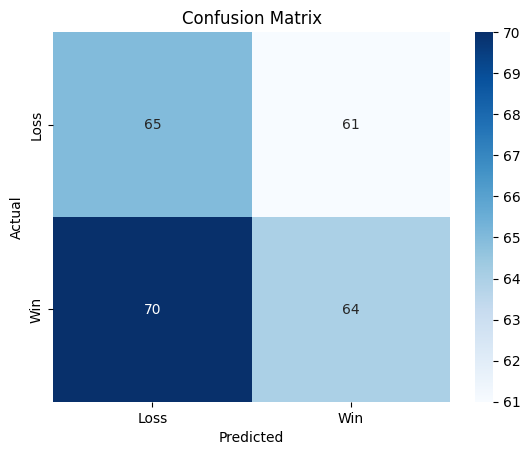

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(Y_test, pred)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')

# Add labels, title, and ticks to the plot
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks([0.5, 1.5], ['Loss', 'Win'])
plt.plot(1, 1)
plt.yticks([0.5, 1.5], ['Loss', 'Win'])

# Display the plot
plt.show()

In [26]:
from sklearn.metrics import classification_report

# Generate a classification report
classification_rep = classification_report(Y_test, pred)
print(classification_rep)

              precision    recall  f1-score   support

           0       0.48      0.52      0.50       126
           1       0.51      0.48      0.49       134

    accuracy                           0.50       260
   macro avg       0.50      0.50      0.50       260
weighted avg       0.50      0.50      0.50       260

